# 01_summary_statistics.ipynb

In [1]:
import sys
sys.path.append('..')
import contextily as cx
import figure_utilities
import figure_and_table_constants
from analysis_utilities import produce_summary_statistics
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

# Store paths.
INPUT_DATA_UNRESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/unrestricted.csv"
INPUT_DATA_RESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/zestimates_analysis.csv"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/tables"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
unrestricted_df = unrestricted_df.reset_index()

/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_32671/795773291.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from P

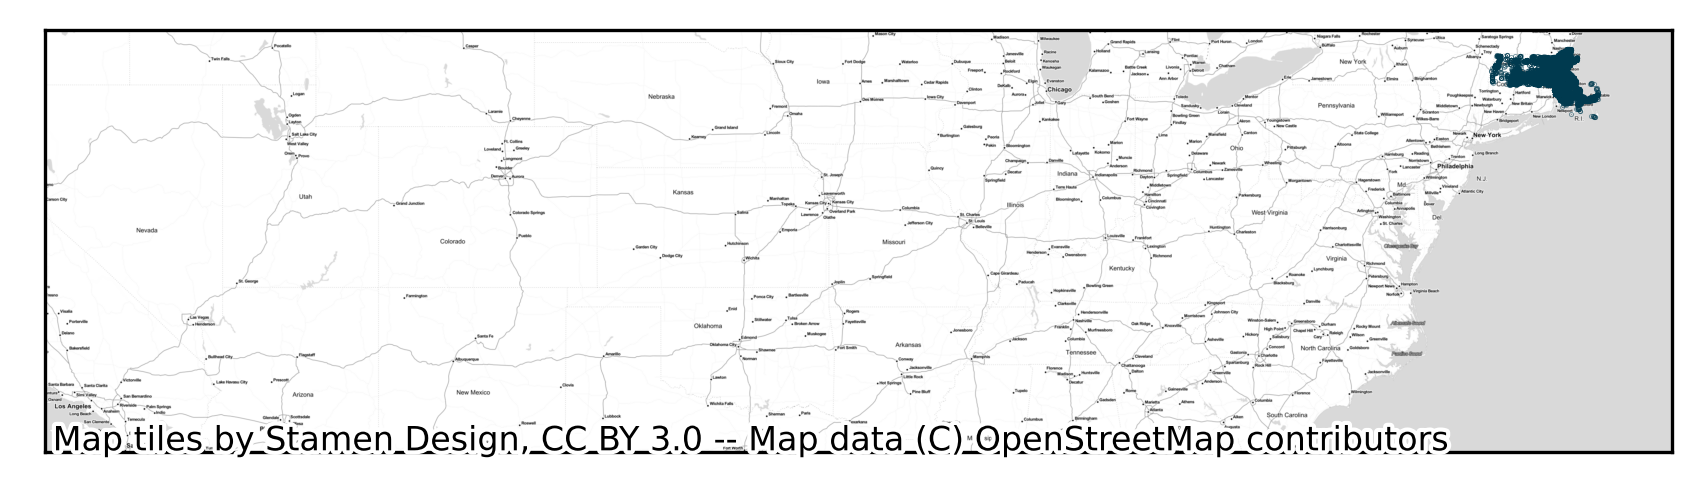

In [2]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color=figure_and_table_constants.Colors.P3,
                      markersize=0.05,
                      alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

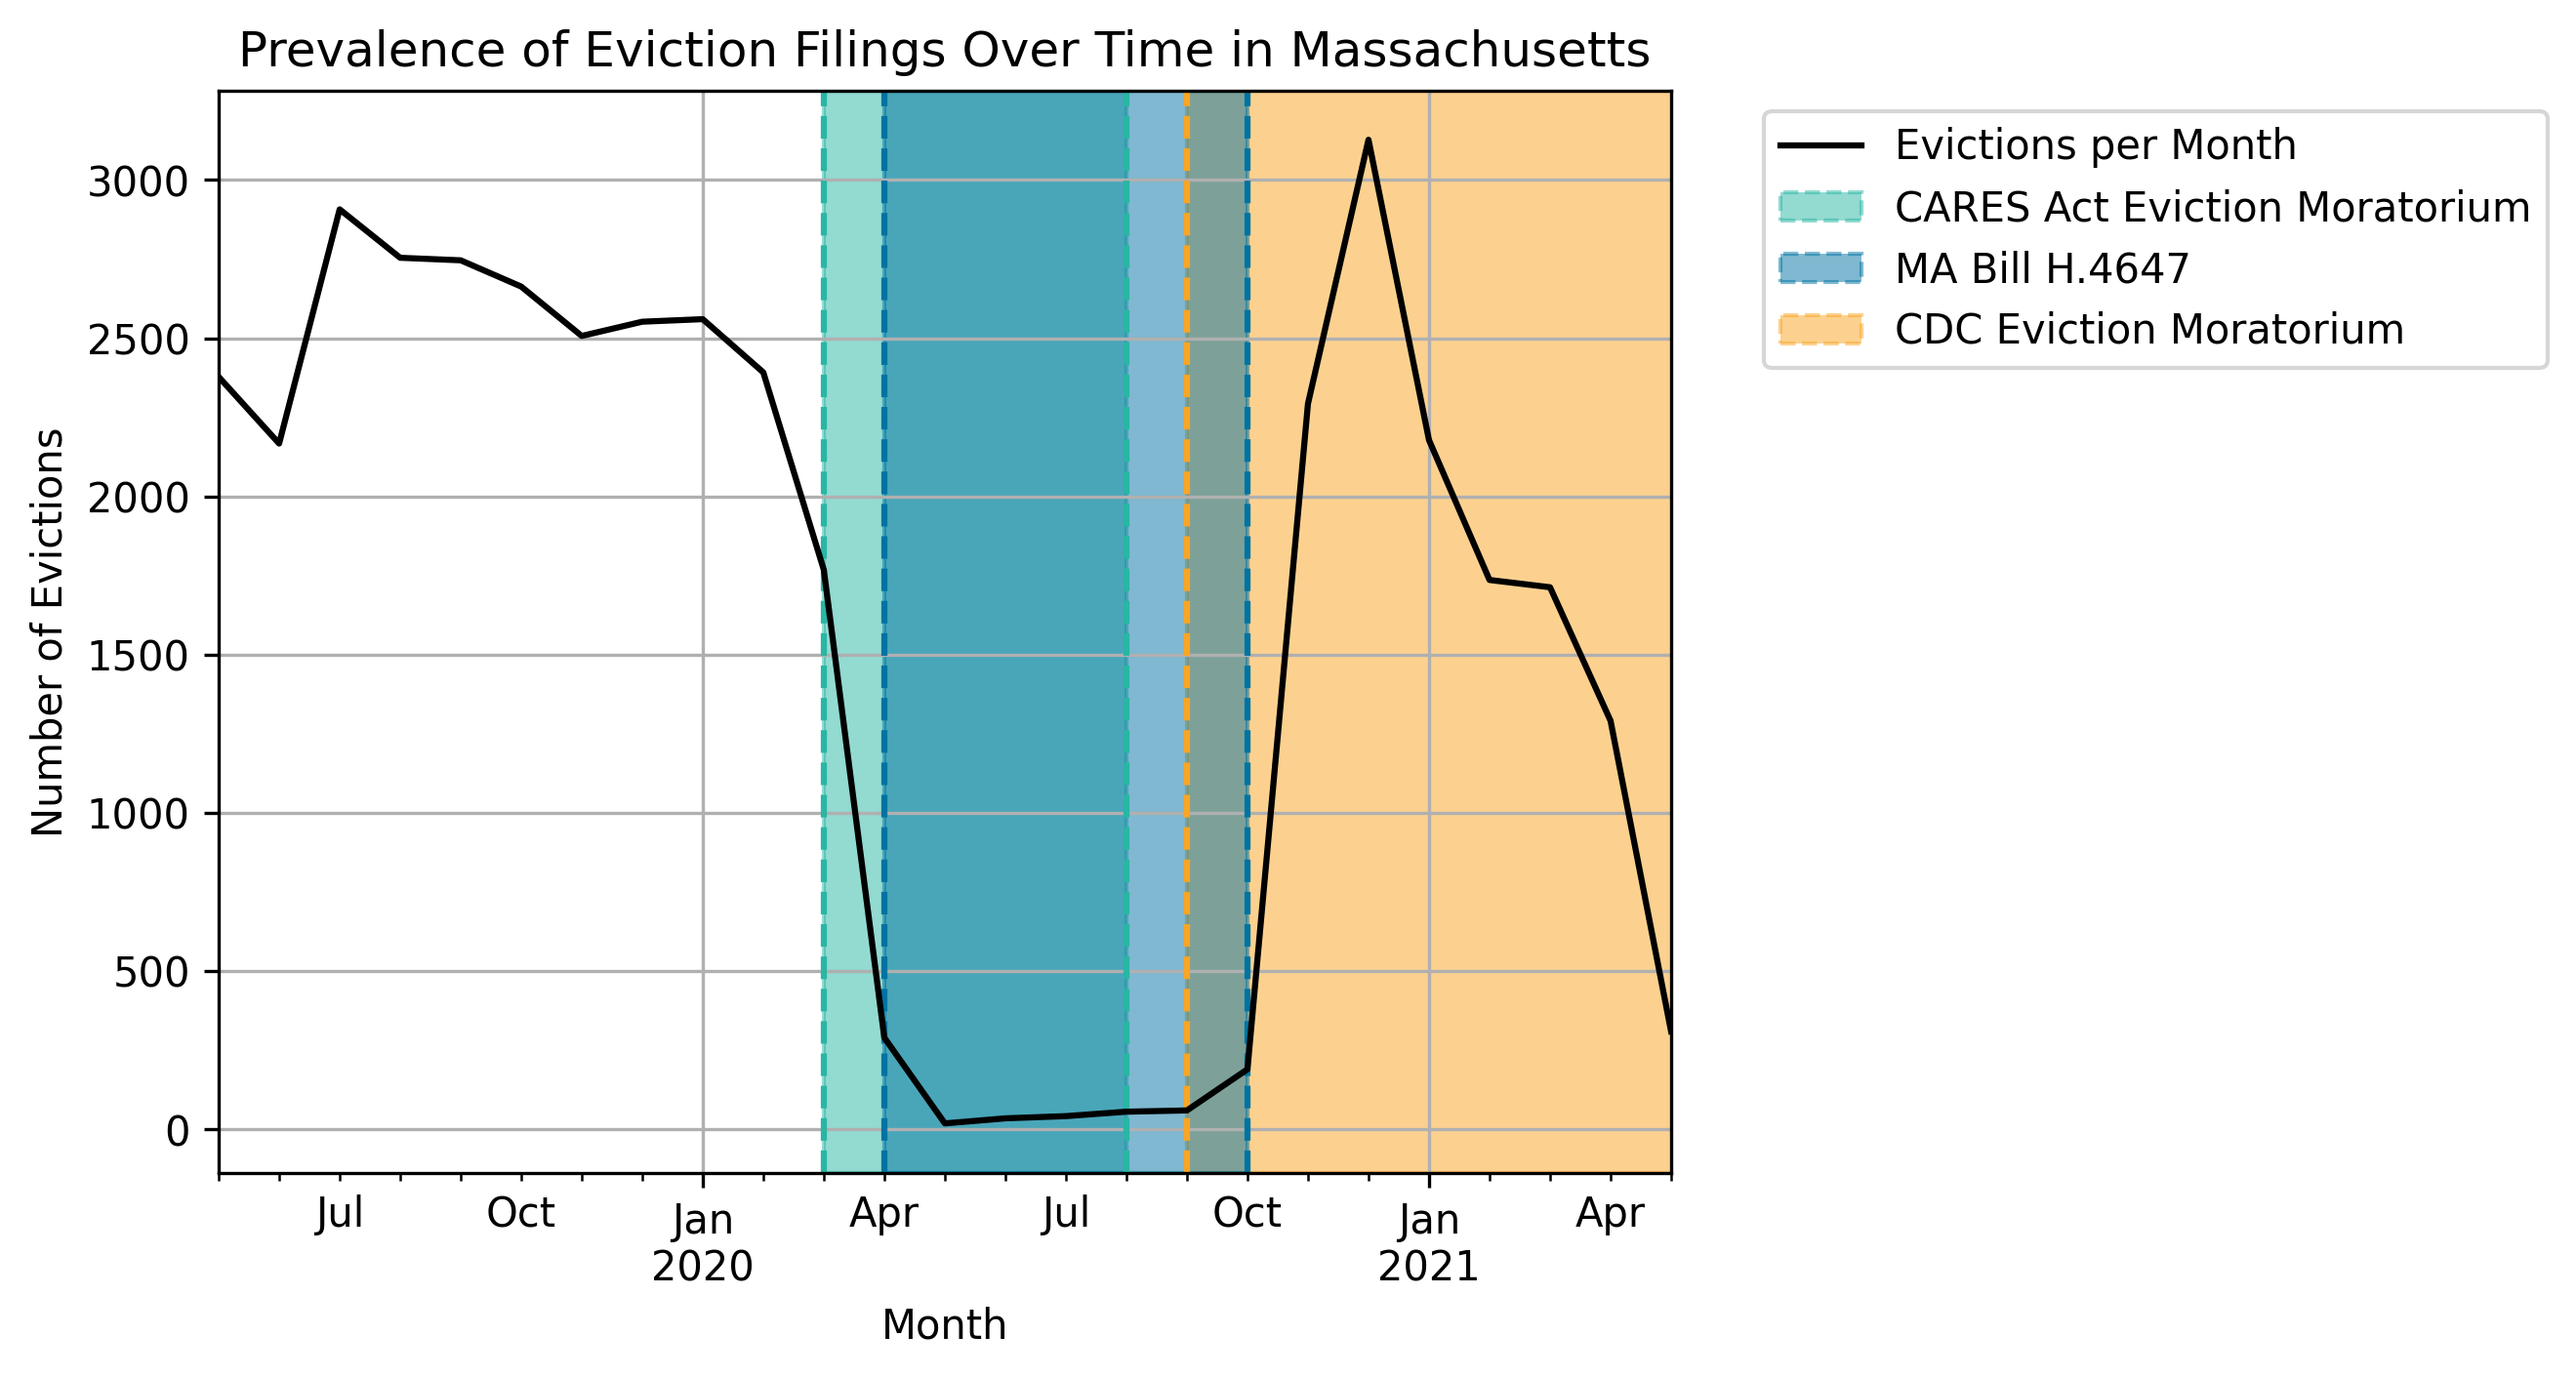

In [3]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_title("Prevalence of Eviction Filings Over Time in Massachusetts")
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [4]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'file_date'
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(unrestricted_df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

Mean  \
Panel                            Variable                                                           
Panel A: Pre-treatment Outcomes  pre_treatment_change_in_group_0_crimes_100m            -0.080891   
                                 pre_treatment_change_in_group_0_crimes_150m            -0.189940   
                                 pre_treatment_change_in_group_0_crimes_200m            -0.364904   
                                 pre_treatment_change_in_group_0_crimes_50m             -0.013502   
                                 pre_treatment_change_in_group_1_crimes_100m             0.001964   
...                                                                                           ...   
Panel F: Post-treatment Outcomes group_3_crimes_200m_2_years_relative_to_treatment       0.330849   
                                 group_3_crimes_50m_1_years_relative_to_treatment        0.024893   
                                 group_3_crimes_50m_2_years_relative_to_treatment        0.026314   
                                 zestimate_1_years_relative_to_treatment            421590.212067   
                                 zestimate_2_years_relative_to_treatment            477931.835124   

                                                                                      Median  \
Panel                            Variable                                                      
Panel A: Pre-treatment Outcomes  pre_treatment_change_in_group_0_crimes_100m             0.0   
                                 pre_treatment_change_in_group_0_crimes_150m             0.0   
                                 pre_treatment_change_in_group_0_crimes_200m             0.0   
                                 pre_treatment_change_in_group_0_crimes_50m              0.0   
                                 pre_treatment_change_in_group_1_crimes_100m             0.0   
...                                                                                      ...   
Panel F: Post-treatment Outcomes group_3_crimes_200m_2_years_relative_to_treatment       0.0   
                                 group_3_crimes_50m_1_years_relative_to_treatment        0.0   
                                 group_3_crimes_50m_2_years_relative_to_treatment        0.0   
                                 zestimate_1_years_relative_to_treatment            347444.0   
                                 zestimate_2_years_relative_to_treatment            393800.0   

                                                                                             S.D.  \
Panel                            Variable                                                           
Panel A: Pre-treatment Outcomes  pre_treatment_change_in_group_0_crimes_100m             1.653648   
                                 pre_treatment_change_in_group_0_crimes_150m             2.744997   
                                 pre_treatment_change_in_group_0_crimes_200m             3.677496   
                                 pre_treatment_change_in_group_0_crimes_50m              0.815372   
                                 pre_treatment_change_in_group_1_crimes_100m             0.386724   
...                                                                                           ...   
Panel F: Post-treatment Outcomes group_3_crimes_200m_2_years_relative_to_treatment       1.497768   
                                 group_3_crimes_50m_1_years_relative_to_treatment        0.299049   
                                 group_3_crimes_50m_2_years_relative_to_treatment        0.205867   
                                 zestimate_1_years_relative_to_treatment            344333.235331   
                                 zestimate_2_years_relative_to_treatment            457699.055898   

                                                                                          N  
Panel                            Variable                                                    
Panel A: Pre-treatment Outco

In [5]:
# Load restricted data.
restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
restricted_df = restricted_df.dropna(subset=['file_date'])
print(f"Limiting sample to {len(restricted_df)} evictions for which we observe the filing date and the latest docket date.")

# Create dictionaries to map between string representation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

Limiting sample to 4706 evictions for which we observe the filing date and the latest docket date.


In [6]:
treatment_timings = (restricted_df
                     .groupby([treatment_month_variable, 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index=treatment_month_variable, columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Filing Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Filing Month")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
Filing Month,,,
All Filing Months,2267.0,2439.0,1.000000
2019-05,108.0,156.0,0.056099
2019-06,89.0,151.0,0.050999
2019-07,94.0,198.0,0.062048
2019-08,104.0,177.0,0.059711
2019-09,108.0,156.0,0.056099
2019-10,111.0,148.0,0.055036
2019-11,82.0,138.0,0.046749
2019-12,84.0,171.0,0.054186
